In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier


In [12]:
# Definition of paths
data_dir = os.path.join(os.getcwd(), '../Dataset')

raw_data_dir = os.path.join(data_dir, 'raw')
ids_mapping = os.path.join(raw_data_dir, 'IDS_mapping.csv')
diabetes_data = os.path.join(raw_data_dir, 'diabetic_data.csv')

mapping_data_dir = os.path.join(data_dir, 'Mapping')
os.makedirs(mapping_data_dir, exist_ok=True)

preprocessed_out_dir = os.path.join(data_dir, 'Preprocessed')
os.makedirs(preprocessed_out_dir, exist_ok=True)

admission_type_mapping_data = os.path.join(mapping_data_dir, 'admission_type_mapping.csv')
discharge_disposition_data = os.path.join(mapping_data_dir, 'discharge_disposition_mapping.csv')
admission_source_mapping_data = os.path.join(mapping_data_dir, 'admission_source_mapping.csv')

preprocessed_saved_filepath = os.path.join(preprocessed_out_dir, 'preprocessed.pkl')

In [13]:
df = pd.read_pickle(preprocessed_saved_filepath)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69987 entries, 0 to 101765
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   encounter_id              69987 non-null  int64   
 1   patient_nbr               69987 non-null  int64   
 2   race                      69987 non-null  category
 3   gender                    69987 non-null  object  
 4   age                       69987 non-null  object  
 5   admission_type_id         69987 non-null  category
 6   discharge_disposition_id  69987 non-null  category
 7   admission_source_id       69987 non-null  category
 8   time_in_hospital          69987 non-null  int64   
 9   medical_specialty         69987 non-null  category
 10  num_lab_procedures        69987 non-null  int64   
 11  num_procedures            69987 non-null  int64   
 12  num_medications           69987 non-null  int64   
 13  number_outpatient         69987 non-null  int64   

In [15]:
print(df.dtypes)

encounter_id                   int64
patient_nbr                    int64
race                        category
gender                        object
age                           object
admission_type_id           category
discharge_disposition_id    category
admission_source_id         category
time_in_hospital               int64
medical_specialty           category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
diag_1                      category
diag_2                      category
diag_3                      category
number_diagnoses               int64
max_glu_serum                  int64
A1Cresult                      int64
metformin                      int64
repaglinide                    int64
glimepiride                    int64
glipizide                      int64
glyburide                      int64
p

In [16]:
for col in df.columns:
    if 'gender' in col:
        df[col] = df[col].astype('category')

In [17]:
df["readmitted"] = df["readmitted"].map({"YES": 1, "NO": 0})

In [18]:
df.drop(columns=["encounter_id", "patient_nbr", "age", "max_glu_serum", "A1Cresult", "metformin", "repaglinide", "glimepiride", "glipizide", "glyburide", "pioglitazone", "rosiglitazone", "insulin"], inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69987 entries, 0 to 101765
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      69987 non-null  category
 1   gender                    69987 non-null  category
 2   admission_type_id         69987 non-null  category
 3   discharge_disposition_id  69987 non-null  category
 4   admission_source_id       69987 non-null  category
 5   time_in_hospital          69987 non-null  int64   
 6   medical_specialty         69987 non-null  category
 7   num_lab_procedures        69987 non-null  int64   
 8   num_procedures            69987 non-null  int64   
 9   num_medications           69987 non-null  int64   
 10  number_outpatient         69987 non-null  int64   
 11  number_emergency          69987 non-null  int64   
 12  number_inpatient          69987 non-null  int64   
 13  diag_1                    69987 non-null  category

In [20]:
X = df.drop('readmitted', axis=1)
y = df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
categorical_cols = X.select_dtypes(include=["category"]).columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns

numerical_transformer = SimpleImputer(strategy="median")
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Step 3: Build the Random Forest pipeline
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")),
    ]
)

In [22]:
# Train the model
model.fit(X_train, y_train)

c:\Users\ic019797\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:02:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_freque...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [23]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO", "YES"])
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 0.63
Precision: 0.57
Recall: 0.37
F1 Score: 0.45


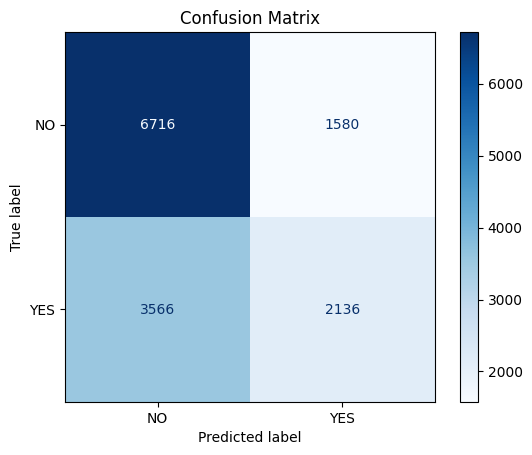

In [24]:
evaluate_model(model, X_test, y_test)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\ic019797\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:13:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'classifier__colsample_bytree': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 300, 'classifier__subsample': 0.7}
Accuracy: 0.63
Precision: 0.58
Recall: 0.37
F1 Score: 0.45


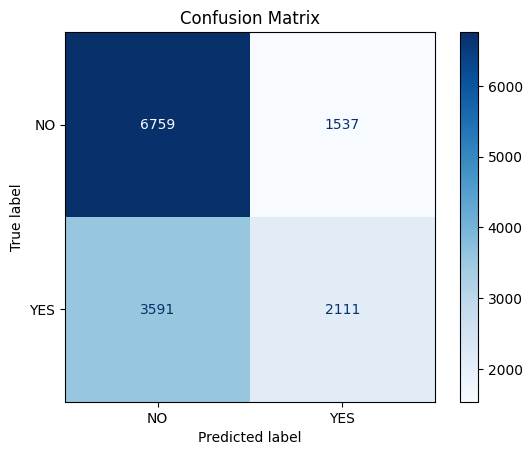

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [3, 6, 10],
    "classifier__learning_rate": [0.01, 0.1, 0.3],
    "classifier__subsample": [0.5, 0.7, 1],
    "classifier__colsample_bytree": [0.5, 0.7, 1]
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

evaluate_model(grid_search.best_estimator_, X_test, y_test)